<div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="width: 20%; text-align: left; margin-left: 10px;">
        <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRyUtYn-FHY0YTZMTs9yRu8I17EMEVCa_zXow&s" alt="Web Fundación Progreso y Salud" style="width: 100%;"/>
    </div>
    <div style="width: 60%; margin-right: 70px;">
        <p style="text-align: right; font-weight: bold; font-size: 2em; margin-top: 30px;">
            Mesh classificator
        </p>
        <p style="text-align: right; color: #666">
            Proyect: MedicoderMESH
        </p>
        <p style="text-align: right; color: #666">
            Juan Luis González Rodríguez
        </p>
    </div>
</div>

# 0.Libraries

In [7]:
#!pip install matplotlib==3.8.3

In [8]:
!pip install accelerate -U

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from tqdm import tqdm
import concurrent.futures
from statistics import median, stdev
import sys

# 1. Functions

In [10]:
def predict_most_likely_mesh(abstract, model_path, tokenizer, label_encoder):
    """
    Predicts the most likely MeSH term for a given abstract

    :param abstract: str, the abstract to predict the MeSH term for
    :param model_path: str, the path to the model to use
    :param tokenizer: BertTokenizerFast, the tokenizer to use
    :param label_encoder: LabelEncoder, the label encoder to use

    :return: str, the most likely MeSH term"""
    model = RobertaForSequenceClassification.from_pretrained(model_path)

    inputs = tokenizer(abstract, return_tensors="pt")

    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label_idx = logits.argmax().item()
    predicted_label = label_encoder.inverse_transform([predicted_label_idx])

    return predicted_label[0]

In [11]:
def top_probable_mesh(text, model_path, tokenizer, label_encoder, n=5):
    """
    Predicts the n most likely MeSH terms for a given abstract

    Params:
    text: str, the abstract to predict the MeSH term for
    model_path: str, the path to the model to use
    tokenizer: BertTokenizerFast, the tokenizer to use
    label_encoder: LabelEncoder, the label encoder to use
    n: int, the number of MeSH terms to return

    Returns:
    df_probabilities: pd.DataFrame, a dataframe with the n most likely MeSH terms and their probabilities
    """
    model = RobertaForSequenceClassification.from_pretrained(model_path)

    inputs = tokenizer(text, return_tensors="pt")

    outputs = model(**inputs)

    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    dictionary_probabilites = dict(zip(label_encoder.classes_, probabilities.detach().numpy()[0]))
    dictionary_probabilites = {k: f'{v*100:.3f}' for k, v in dictionary_probabilites.items()}

    df_probabilities = pd.DataFrame(dictionary_probabilites.items(), columns=['MESH_MAJOR_TOPIC', 'Probability (%)'])
    df_probabilities = df_probabilities.sort_values(by='Probability (%)', ascending=False)

    df_probabilities = df_probabilities.head(n)
    df_probabilities = df_probabilities.reset_index(drop=True)
    return df_probabilities

# 2. Data preprocessing

In [12]:
df =  pd.read_csv('/content/projects_pubmed.csv', quotechar='"', skipinitialspace=True)

In [13]:
min_pub = 40

filter_df = [group for group in df.groupby('MESH_MAJOR_TOPIC') if len(group[1]) >= min_pub]
filter_df = pd.concat([group[1] for group in filter_df])
filter_df['MESH_MAJOR_TOPIC'].value_counts().values

print(f'There are {len(filter_df)} publications with at least {min_pub} publications in the same MESH_MAJOR_TOPIC')
print(f'There are {len(filter_df["MESH_MAJOR_TOPIC"].unique())} unique MESH_MAJOR_TOPICs in the filtered dataset')

There are 2812 publications with at least 40 publications in the same MESH_MAJOR_TOPIC
There are 61 unique MESH_MAJOR_TOPICs in the filtered dataset


In [14]:
filter_df = filter_df[['ABSTRACT', 'MESH_MAJOR_TOPIC']]

In [15]:
# Encode the Mesh Major Topic
label_encoder = LabelEncoder()

label_encoder.fit(filter_df['MESH_MAJOR_TOPIC'])

filter_df['label'] = label_encoder.transform(filter_df['MESH_MAJOR_TOPIC'])

In [16]:
filter_df.rename(columns={'ABSTRACT':'abstract', 'MESH_MAJOR_TOPIC':'labels decoded'}, inplace=True)
filter_df.reset_index(drop=True, inplace=True)

print(filter_df.info())
display(filter_df.head())
print(f'Shape of the filtered dataset: {filter_df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812 entries, 0 to 2811
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   abstract        2812 non-null   object
 1   labels decoded  2812 non-null   object
 2   label           2812 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 66.0+ KB
None


,abstract,labels decoded,label
0,El cáncer gástrico representa una de las neopl...,Adenocarcinoma,0
1,El equipo multidisciplinario de cáncer de prós...,Adenocarcinoma,0
2,Antecedentes y objetivos Existen pocos estudio...,Adenocarcinoma,0
3,La principal relevancia clínica del esófago de...,Adenocarcinoma,0
4,Antecedentes y objetivo El tratamiento del ade...,Adenocarcinoma,0


Shape of the filtered dataset: (2812, 3)


In [17]:
tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-biomedical-clinical-es')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/540k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

In [18]:
# Select a random abstract
np.random.seed(42)
i = np.random.randint(0, len(filter_df))

abs_original = filter_df.loc[i, 'abstract']
abs_tokenized = tokenizer.tokenize(abs_original)
abs_encoded = tokenizer.encode_plus(abs_original)

# Reconstruc the abstract from the tokens
abs_reconstructed = tokenizer.decode(abs_encoded['input_ids'], verbose=False)

# Print the results
print(f'Original abstract:\n{abs_original}')
print(f'\nTokenized abstract:\n{abs_tokenized}')
print(f'\nInternal representation of the tokenized abstract:\n{abs_encoded}')
print(f'\nReconstructed abstract:\n{abs_reconstructed}')

Original abstract:
Introducción El dolor está considerado como un grave problema en el entorno residencial afectando entre un 49 y un 83% de los residentes. El proceso evolutivo de la enfermedad de Alzheimer puede conllevar dificultades de comunicación y comprensión de las escalas de evaluación de dolor, dificultando su evaluación y tratamiento. El objetivo principal de este estudio fue validar la versión española del PAINAD (PAINAD-Sp) y evaluar su aplicabilidad en un Centro Gerontológico en España. Material y métodos Veinte usuarias diagnosticadas de demencia avanzada fueron observadas por 5 observadores con diferentes perfiles profesionales durante 5min en 3 condiciones: reposo, durante actividad agradable y en situación de dolor. La PAINAD-Sp fue administrada simultáneamente a una escala analógica visual. Resultados Los resultados muestran que el alfa de Cronbach se encontraba entre 0,467 y 0,827 (con una media de 0,692, que subía si el ítem de respiración se eliminaba). La fiabili

In [19]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):

        text = self.texts[idx]

        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, max_length=self.max_len, padding='max_length')
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

# Split your data
train_texts, test_texts, train_labels, test_labels = train_test_split(filter_df['abstract'],
                                                                      filter_df['label'],
                                                                      test_size=0.25,
                                                                      stratify=filter_df['label'])
train_texts = train_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create your datasets
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

In [20]:
# Plot a sample of the dataset
train_dataset[0]

{'input_ids': tensor([    0,  9797,   470, 49937,  2817,   379,  4300, 19593,   296,   308,
          3146, 19593, 15580,    15,   300, 11757,   331, 21675, 10004,  7931,
            17,   470,  1612,   331,  1090,   296,  2966,   308,   990,  2446,
           262,   511,  8842,  5260,   290,  1486,   363,  3201,   262,   284,
          4112,  1356,    15,  1263,   290,   636,    17, 16355,  2446,  3106,
          1011,   262,  2395,   610,    15,   300,   313, 13969,   262, 49937,
          2817,   379,  4300,   780,   363, 10359,  7149,   262,   363, 20165,
         31418,    15,   288,   297,  3194,   262,   308,   865,  2874,  4582,
            17,   452,   297,  2052,  2917,  5464,   363, 13321,   262,   284,
          3055,   269,   318,   388,   610,    15,   300,   313, 17092,  1366,
         10359,    17, 14688,   470, 49937,  2817,   379,  4300, 19593,   296,
           308,  3146, 19593,  4672,  6740,   296, 13734,    15,   284, 11332,
          1356,   296, 24864,    17,   

# 3. Training

In [21]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted',zero_division=1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [22]:
# Get the number of labels
num_labels = len(filter_df['label'].unique())

config = RobertaConfig.from_pretrained('PlanTL-GOB-ES/roberta-base-biomedical-clinical-es',num_labels=num_labels,
                                    hidden_dropout_prob=0.2, attention_probs_dropout_prob=0.2)
model = RobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-biomedical-clinical-es',config=config)
print(model.config)
print(model.config.num_labels)

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "_name_or_path": "PlanTL-GOB-ES/roberta-base-biomedical-clinical-es",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.2,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "

In [23]:
training_args = TrainingArguments(
    learning_rate=1e-5,
    warmup_steps=2000,
    output_dir='./results',
    weight_decay=0.015,
    num_train_epochs=4,                     # Total number of training epochs
    per_device_train_batch_size=2,          # Batch size for training
    per_device_eval_batch_size=8,           # Batch size for evaluation
    logging_dir='./logs',                   # Directory for storing logs
    logging_steps=100,                      # Log every X steps
    evaluation_strategy="steps",            # Evaluate every X steps
    eval_steps=1000,                         # Evaluate every X steps
    report_to="tensorboard",                # Enables logging to TensorBoard
    save_strategy="steps",               # Save every X steps (should match evaluation_strategy for best results)
    save_steps=1000,                      # Save every 1000 steps
    load_best_model_at_end=True,         # Load the best model at the end
    metric_for_best_model="f1",    #bb Use f1 for best model selection
    greater_is_better=True,              # Set to False if a lower metric is better (e.g., loss)
    max_grad_norm=0.8,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [24]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,4.066200,4.029311,0.065434,0.041284,0.665575,0.065434
2000,3.226800,2.913620,0.601707,0.542808,0.727185,0.601707
3000,2.420700,2.103068,0.694168,0.641211,0.778819,0.694168
4000,2.071900,1.841817,0.708393,0.661917,0.780816,0.708393


TrainOutput(global_step=4220, training_loss=3.1137008856823094, metrics={'train_runtime': 1160.5176, 'train_samples_per_second': 7.269, 'train_steps_per_second': 3.636, 'total_flos': 2220780670267392.0, 'train_loss': 3.1137008856823094, 'epoch': 4.0})

In [25]:
trainer.evaluate()

{'eval_loss': 1.841817021369934,
 'eval_accuracy': 0.7083926031294452,
 'eval_f1': 0.6619171517944097,
 'eval_precision': 0.7808164990868266,
 'eval_recall': 0.7083926031294452,
 'eval_runtime': 22.0822,
 'eval_samples_per_second': 31.836,
 'eval_steps_per_second': 3.985,
 'epoch': 4.0}

In [26]:
model.save_pretrained("model")

# 4. Test

In [27]:
text = "El melanoma es la forma más letal de cáncer de piel, aunque la cirugía a menudo es curativa cuando se combina con la detección y prevención tempranas. En el cáncer recurrente o avanzado, la aparición de la quimioterapia, la terapia dirigida y los inhibidores de puntos de control inmunitarios ha demostrado resultados clínicos prometedores. Estos enfoques pueden detener notablemente la progresión de la enfermedad durante muchos años, aunque están limitados por la adquisición de resistencia. El desarrollo y la aprobación de terapias combinadas han cambiado aún más el paradigma de tratamiento para ciertos melanomas. Esta revisión se centra en el estado actual de la epidemiología del melanoma y en los avances recientes en la detección del melanoma, la clasificación histopatológica, la escisión en etapas (es decir, escisión local amplia, biopsia de ganglio centinela y cirugía micrográfica de Mohs), y el tratamiento sistémico."
real_label = "Melanoma"
label_predicted = predict_most_likely_mesh(text, "model", tokenizer, label_encoder)

print(f'The abstract is:\n{text}')
print(f'\nThe real label is:\t{real_label}')
print(f'The predicted label is:', end='\t')

if real_label == label_predicted:
    print(f'\033[92m{label_predicted}\033[0m')
else:
    print(f'\033[91m{label_predicted}\033[0m')

The abstract is:
El melanoma es la forma más letal de cáncer de piel, aunque la cirugía a menudo es curativa cuando se combina con la detección y prevención tempranas. En el cáncer recurrente o avanzado, la aparición de la quimioterapia, la terapia dirigida y los inhibidores de puntos de control inmunitarios ha demostrado resultados clínicos prometedores. Estos enfoques pueden detener notablemente la progresión de la enfermedad durante muchos años, aunque están limitados por la adquisición de resistencia. El desarrollo y la aprobación de terapias combinadas han cambiado aún más el paradigma de tratamiento para ciertos melanomas. Esta revisión se centra en el estado actual de la epidemiología del melanoma y en los avances recientes en la detección del melanoma, la clasificación histopatológica, la escisión en etapas (es decir, escisión local amplia, biopsia de ganglio centinela y cirugía micrográfica de Mohs), y el tratamiento sistémico.

The real label is:	Melanoma
The predicted label 

In [28]:
print('\nTop 5 probable MeSH terms:')
top_probable_mesh(text, "model", tokenizer, label_encoder, n=5)


Top 5 probable MeSH terms:


,MESH_MAJOR_TOPIC,Probability (%)
0,"Carcinoma, Basal Cell",5.171
1,"Carcinoma, Squamous Cell",3.749
2,Lymphatic Metastasis,3.726
3,"Carcinoma, Non-Small-Cell Lung",3.301
4,"Neoplasm Recurrence, Local",3.290


In [46]:
tuple_evaluation = []
model = RobertaForSequenceClassification.from_pretrained("model")

def process_row(i):
    row = test_dataset[i]
    real_label = row['labels'].item()
    inputs = {k: v.unsqueeze(0) for k, v in row.items() if k != 'labels'}
    outputs = model(**inputs)
    predicted_label_idx = outputs.logits.argmax().item()
    return (real_label, predicted_label_idx)

for i in range(len(test_dataset)):
    print(f"{i+1}/{len(test_dataset)}", end="\n")
    result = process_row(i)
    tuple_evaluation.append(result)

1/703
2/703
3/703
4/703
5/703
6/703
7/703
8/703
9/703
10/703
11/703
12/703
13/703
14/703
15/703
16/703
17/703
18/703
19/703
20/703
21/703
22/703
23/703
24/703
25/703
26/703
27/703
28/703
29/703
30/703
31/703
32/703
33/703
34/703
35/703
36/703
37/703
38/703
39/703
40/703
41/703
42/703
43/703
44/703
45/703
46/703
47/703
48/703
49/703
50/703
51/703
52/703
53/703
54/703
55/703
56/703
57/703
58/703
59/703
60/703
61/703
62/703
63/703
64/703
65/703
66/703
67/703
68/703
69/703
70/703
71/703
72/703
73/703
74/703
75/703
76/703
77/703
78/703
79/703
80/703
81/703
82/703
83/703
84/703
85/703
86/703
87/703
88/703
89/703
90/703
91/703
92/703
93/703
94/703
95/703
96/703
97/703
98/703
99/703
100/703
101/703
102/703
103/703
104/703
105/703
106/703
107/703
108/703
109/703
110/703
111/703
112/703
113/703
114/703
115/703
116/703
117/703
118/703
119/703
120/703
121/703
122/703
123/703
124/703
125/703
126/703
127/703
128/703
129/703
130/703
131/703
132/703
133/703
134/703
135/703
136/703
137/703
138/703
139/

In [47]:
num_labels = len(filter_df['label'].unique())

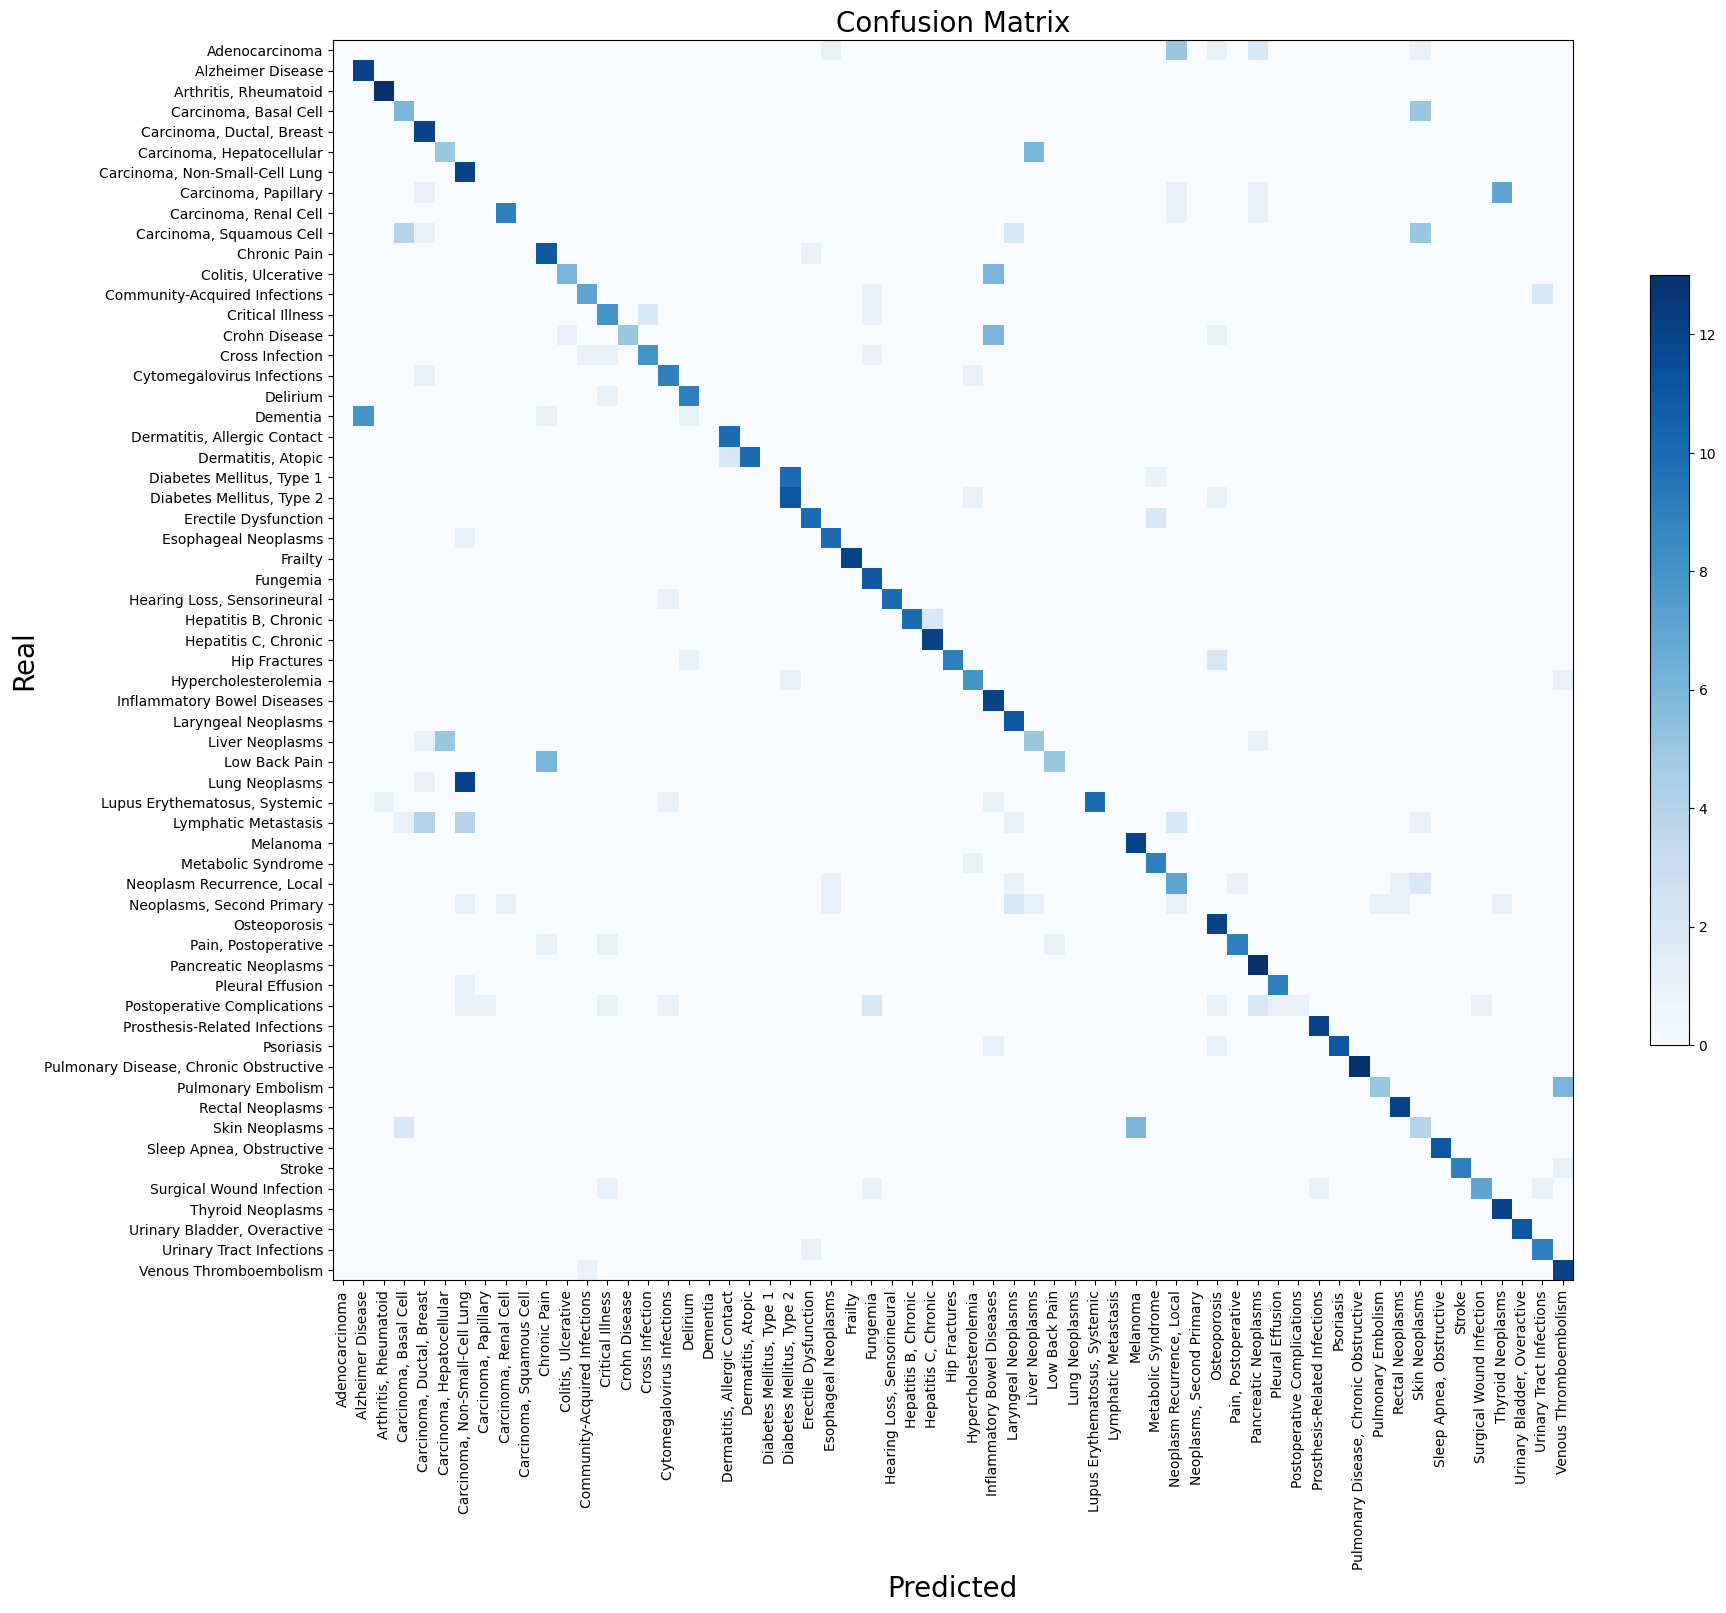

In [48]:
tuple_evaluation = np.array(tuple_evaluation)
real_labels = tuple_evaluation[:, 0]
predicted_labels = tuple_evaluation[:, 1]

confusion_matrix = confusion_matrix(real_labels, predicted_labels)

plt.figure(figsize=(20, 20))
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.xticks(range(num_labels), label_encoder.classes_, rotation=90)
plt.yticks(range(num_labels), label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=20)
plt.colorbar(shrink=0.5)
plt.show()

In [49]:
real_labels = [real_label_idx for real_label_idx, _ in tuple_evaluation]
predicted_labels = [predicted_label_idx for _, predicted_label_idx in tuple_evaluation]

accuracy = accuracy_score(real_labels, predicted_labels)
precision = precision_score(real_labels, predicted_labels, average='weighted')
recall = recall_score(real_labels, predicted_labels, average='weighted')
f1 = f1_score(real_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1: {f1:.2f}')


Accuracy: 0.71
Precision: 0.67
Recall: 0.71
F1: 0.66


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# Number of iterations
n = 100

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for _ in range(n):
    # Create a random model
    random_model = list(np.random.randint(0, num_labels, len(test_dataset)))

    real_labels = [real_label_idx for real_label_idx, _ in tuple_evaluation]
    predicted_labels = random_model

    # Calculate metrics
    rand_accuracy = accuracy_score(real_labels, predicted_labels)
    rand_precision = precision_score(real_labels, predicted_labels, average='weighted')
    rand_recall = recall_score(real_labels, predicted_labels, average='weighted')
    rand_f1 = f1_score(real_labels, predicted_labels, average='weighted')

    # Append metrics to lists
    accuracy_list.append(rand_accuracy)
    precision_list.append(rand_precision)
    recall_list.append(rand_recall)
    f1_list.append(rand_f1)

# Calculate and print median and standard deviation of each metric
print(f"Random model metrics for {n} iterations:")
print(f'Accuracy: Median={median(accuracy_list):.2f}, Std={stdev(accuracy_list):.2f}')
print(f'Precision: Median={median(precision_list):.2f}, Std={stdev(precision_list):.2f}')
print(f'Recall: Median={median(recall_list):.2f}, Std={stdev(recall_list):.2f}')
print(f'F1: Median={median(f1_list):.2f}, Std={stdev(f1_list):.2f}')

Random model metrics for 100 iterations:
Accuracy: Median=0.02, Std=0.00
Precision: Median=0.02, Std=0.01
Recall: Median=0.02, Std=0.00
F1: Median=0.02, Std=0.00
